In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import joblib

In [3]:
from pandas.core.interchange.dataframe_protocol import Column
# Step 1: Load and preprocess the dataset
data = pd.read_csv('/content/TotalBusCurrent.csv')
data.head()

,Date_time,Current
0,2/13/2004,11.799583
1,2/14/2004,11.826283
2,2/15/2004,11.804309
3,2/16/2004,11.803606
4,2/17/2004,11.239218


In [4]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data = data.dropna()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date_time  4812 non-null   datetime64[ns]
 1   Current    4812 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.3 KB


In [6]:
data.describe()

,Current
count,4812.000000
mean,11.116185
std,1.411899
min,0.011111
25%,11.057714
50%,11.549147
75%,11.877175
max,12.714043


In [7]:
# Step 2: Feature Engineering (adding more features as needed)
data['day_of_week'] = data['Date_time'].dt.dayofweek

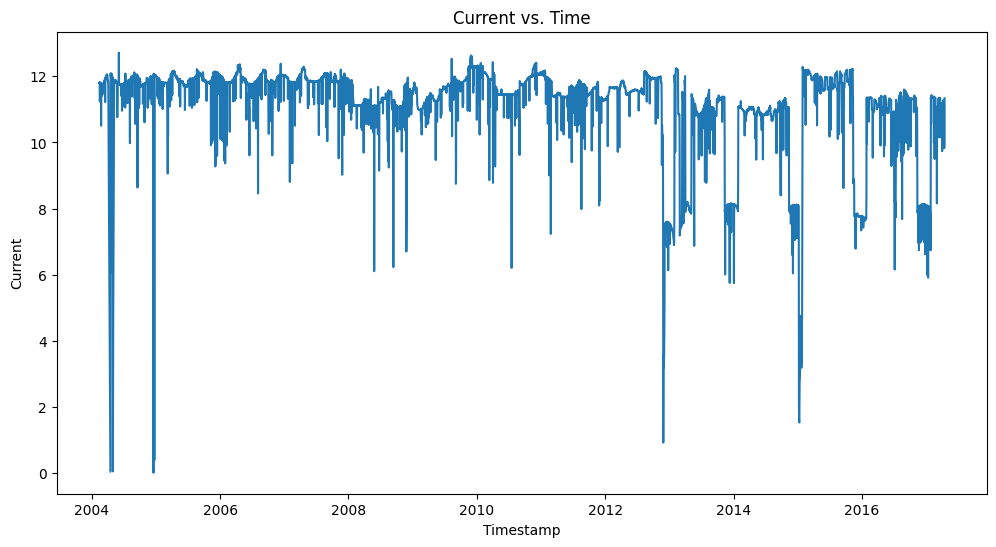

In [8]:
# Step 3: Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['Date_time'], data['Current'])
plt.xlabel('Timestamp')
plt.ylabel('Current')
plt.title('Current vs. Time')
plt.show()

In [11]:
# Step 4: Anomaly Detection with multiple models
def detect_anomalies(data):
    # Initialize arrays to store anomaly scores from different models
    anomaly_scores_if = []
    anomaly_scores_svm = []
    anomaly_scores_lof = []

    # Isolation Forest
    clf_if = IsolationForest(contamination=0.05)
    anomalies_scores_if = clf_if.fit_predict(data[['Current', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_if = np.where(anomalies_scores_if == 1, 1, -1)

    # One-Class SVM
    clf_svm = OneClassSVM(nu=0.05)
    anomalies_scores_svm = clf_svm.fit_predict(data[['Current', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_svm = np.where(anomalies_scores_svm == 1, 1, -1)

    # Local Outlier Factor
    clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    anomalies_scores_lof = clf_lof.fit_predict(data[['Current', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_lof = np.where(anomalies_scores_lof == 1, 1, -1)

    # Stack anomaly scores from different models
    stacked_anomalies = np.column_stack((anomalies_scores_if, anomalies_scores_svm, anomalies_scores_lof))

    # Sum the anomaly scores across models (you can customize the stacking approach)
    final_anomaly_scores = np.sum(stacked_anomalies, axis=1)

    # Define a threshold to identify anomalies
    threshold = np.percentile(final_anomaly_scores, 5)

    # Create a boolean mask for anomalies based on the threshold
    anomalies = final_anomaly_scores > threshold

    return anomalies

# Detect anomalies in the data using multiple models
data['anomalies'] = detect_anomalies(data)
data['anomalies'] = data['anomalies'].astype(int)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [14]:
print(data['anomalies'])

0       1
1       1
2       0
3       1
4       1
       ..
4807    1
4808    1
4809    1
4810    1
4811    1
Name: anomalies, Length: 4812, dtype: int64


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date_time    4812 non-null   datetime64[ns]
 1   Current      4812 non-null   float64       
 2   day_of_week  4812 non-null   int64         
 3   anomalies    4812 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 150.5 KB


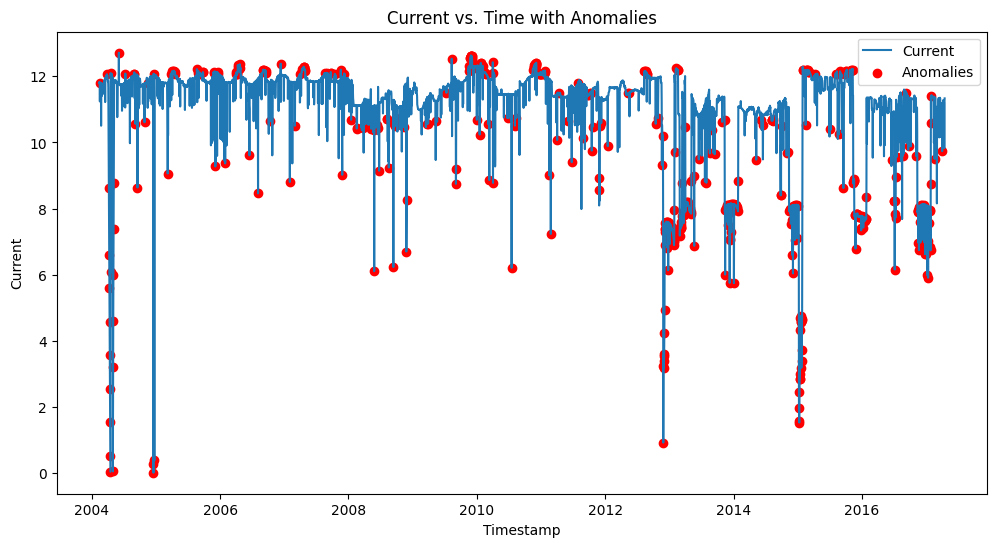

In [15]:
# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['Date_time'], data['Current'], label='Current')
plt.scatter(data[data['anomalies'] == 0]['Date_time'], data[data['anomalies'] == 0]['Current'], c='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Current')
plt.title('Current vs. Time with Anomalies')
plt.legend()
plt.show()


# Model Building
For building model we have splited the dataset in 9:1  ration 9 parts for training and testing and 1 part for validation.

In [18]:
# Step 5: Model Building
X = data[['day_of_week', 'Current']]
y = data['anomalies']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
svm_model = SVC()

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

SVC()

In [20]:
# Make predictions on the validation set
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
svm_pred = svm_model.predict(X_test)

In [21]:
# Stack the predictions from different models
stacked_predictions = [rf_pred, gb_pred, svm_pred]

# Create a VotingClassifier to combine predictions
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('svm', svm_model)
], voting='hard')

In [22]:
# Train the VotingClassifier on the validation set
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier()),
                             ('svm', SVC())])

In [23]:
# Step 6: Model Evaluation
y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9906542056074766
Confusion Matrix:
[[ 87   8]
 [  1 867]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        95
           1       0.99      1.00      0.99       868

    accuracy                           0.99       963
   macro avg       0.99      0.96      0.97       963
weighted avg       0.99      0.99      0.99       963



In [26]:
# Step 8: Predict Anomalies in New Data
# Load and preprocess new data
new_data = pd.read_csv("/content/new_current.csv")
new_data['Date_time'] = pd.to_datetime(new_data['Date_time'])
new_data['day_of_week'] = new_data['Date_time'].dt.dayofweek

In [27]:
# Use the trained model to predict anomalies in new data
new_data['anomalies'] = voting_classifier.predict(new_data[['day_of_week', 'Current']])

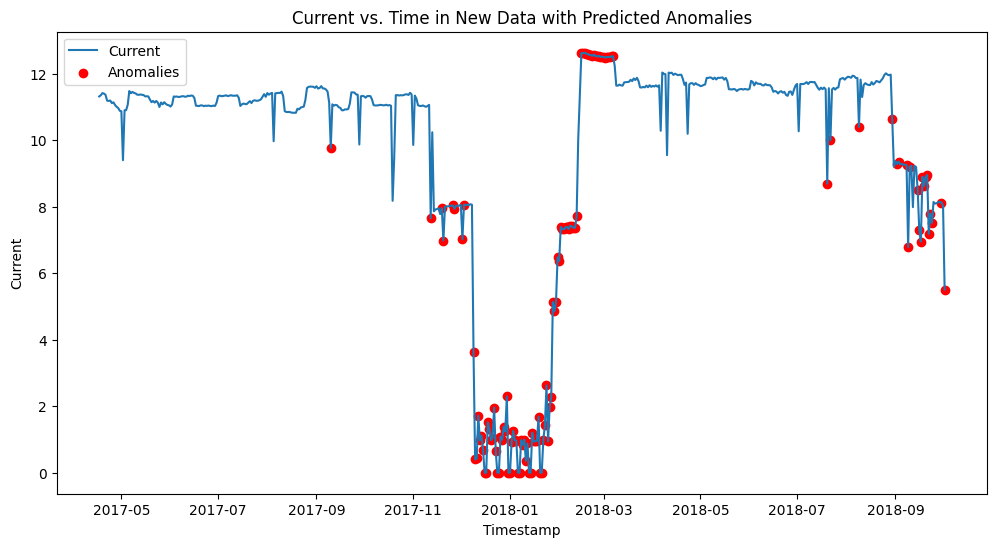

In [29]:
# Visualize anomalies in new data
plt.figure(figsize=(12, 6))
plt.plot(new_data['Date_time'], new_data['Current'], label='Current')
plt.scatter(new_data[new_data['anomalies'] == 0]['Date_time'], new_data[new_data['anomalies'] == 0]['Current'], c='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Current')
plt.title('Current vs. Time in New Data with Predicted Anomalies')
plt.legend()
plt.show()

In [30]:
#Save the model
joblib.dump(voting_classifier, "trained_model_current.pkl")

['trained_model_current.pkl']

In [33]:
#Making API for model deployment
from flask import Flask, request, jsonify
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

app = Flask(__name__)

# Load the trained model
model = joblib.load("trained_model_current.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the POST request
        data = request.get_json(force=True)

        # Preprocess the data (you may need to adjust this based on your preprocessing steps)
        day_of_week = data['day_of_week']
        Current = data['Current']

        # Make predictions using the trained model
        prediction = model.predict([[hour, day_of_week, Current]])

        # Return the prediction as JSON response
        response = {'prediction': int(prediction[0])}
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
